<a href="https://colab.research.google.com/github/delpretemarcus/156StockClosingPricePrediction/blob/main/ClosePriceOnly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error
import numpy

In [2]:

aplurl = 'https://raw.githubusercontent.com/delpretemarcus/156StockClosingPricePrediction/main/HistoricalQuotes.csv'

df = pd.read_csv(aplurl, index_col='Date')

In [3]:
#Data Cleaning --

df.columns = ['Close', 'Volume', 'Open', 'High', 'Low']
df.index = pd.to_datetime(df.index)
df.sort_index()

df.Close = df.Close.apply(lambda x: x[2:]).astype(np.double)
df.Open = df.Open.apply(lambda x: x[2:]).astype(np.double)
df.High = df.High.apply(lambda x: x[2:]).astype(np.double)
df.Low = df.Low.apply(lambda x: x[2:]).astype(np.double)

df = df.reindex(index=df.index[::-1])


In [4]:
df1=df.reset_index()['Close']

In [5]:
df1

0        29.8557
1        29.8357
2        29.9043
3        30.1014
4        31.2786
          ...   
2513    298.1800
2514    288.0800
2515    292.6500
2516    273.5200
2517    273.3600
Name: Close, Length: 2518, dtype: float64

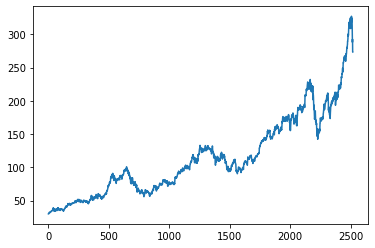

In [6]:
plt.plot(df1)

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
training_size,test_size

(2014, 504)

In [10]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3... t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM. Could have made 3rd dimension w/ open/volume, but seems to work well enough without
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [13]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=60,batch_size=64,verbose=1)

Epoch 1/60
30/30 [==============================] - 32s 529ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 2/60
30/30 [==============================] - 8s 257ms/step - loss: 3.7820e-04 - val_loss: 0.0035
Epoch 3/60
30/30 [==============================] - 7s 247ms/step - loss: 2.2277e-04 - val_loss: 0.0025
Epoch 4/60
30/30 [==============================] - 7s 241ms/step - loss: 2.1739e-04 - val_loss: 0.0019
Epoch 5/60
30/30 [==============================] - 8s 261ms/step - loss: 2.1338e-04 - val_loss: 0.0031
Epoch 6/60
30/30 [==============================] - 8s 256ms/step - loss: 2.1657e-04 - val_loss: 0.0022
Epoch 7/60
30/30 [==============================] - 7s 249ms/step - loss: 2.0075e-04 - val_loss: 0.0020
Epoch 8/60
30/30 [==============================] - 8s 270ms/step - loss: 1.8600e-04 - val_loss: 0.0016
Epoch 9/60
30/30 [==============================] - 8s 257ms/step - loss: 1.8095e-04 - val_loss: 0.0015
Epoch 10/60
30/30 [==============================] - 8s 261ms/step 

In [16]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [17]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

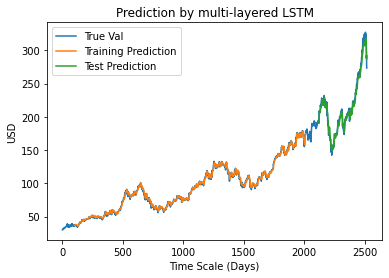

In [29]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label='True Val')
plt.plot(trainPredictPlot, label='Training Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.title('Prediction by multi-layered LSTM')
plt.xlabel('Time Scale (Days)')
plt.ylabel('USD')
plt.legend()
plt.savefig('MultiLayeredAllData.png')
plt.show()

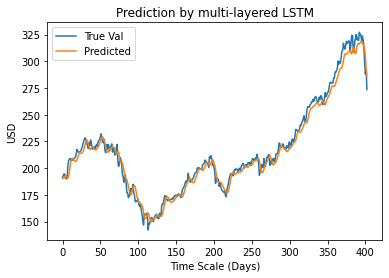

In [28]:
#Plotting just the predicted part
plt.plot(scaler.inverse_transform(df1)[len(train_predict)+(look_back*2)+1:len(df1)-1, :],  label='True Val')
plt.plot(test_predict, label='Predicted')
plt.title('Prediction by multi-layered LSTM')
plt.xlabel('Time Scale (Days)')
plt.ylabel('USD')
plt.legend()
plt.savefig('MultiLayeredTest.png')
plt.show()

In [20]:
y_train

array([0.0241041 , 0.0245443 , 0.02422719, ..., 0.4797627 , 0.48985134,
       0.50152053])

In [21]:
unscaled_y_train = scaler.inverse_transform(np.array(y_train).reshape(-1,1))

In [22]:
train_predict

array([[ 36.711212],
       [ 36.774883],
       [ 36.958855],
       ...,
       [174.73535 ],
       [174.62447 ],
       [174.60461 ]], dtype=float32)

In [23]:
ytest

array([0.54402731, 0.54870171, 0.55482215, 0.55277079, 0.5419087 ,
       0.53831042, 0.53958831, 0.57728618, 0.59709353, 0.59911126,
       0.60274317, 0.59615193, 0.59662273, 0.60210422, 0.59756433,
       0.60207059, 0.60502992, 0.60667774, 0.6170354 , 0.63136126,
       0.62423196, 0.62281955, 0.62285318, 0.62433285, 0.62658598,
       0.6325719 , 0.63849057, 0.64952081, 0.65641471, 0.66515819,
       0.66761309, 0.6626024 , 0.64992435, 0.64387117, 0.63388342,
       0.65244651, 0.64309771, 0.66105548, 0.65241288, 0.63237013,
       0.63358076, 0.63401794, 0.63960032, 0.63163029, 0.6421561 ,
       0.64686413, 0.64091184, 0.65614568, 0.65880235, 0.66391393,
       0.67070694, 0.68008937, 0.66636883, 0.65392618, 0.65217748,
       0.6626024 , 0.62725855, 0.62083545, 0.6465951 , 0.63062143,
       0.64672962, 0.64350125, 0.62611517, 0.63717904, 0.6416853 ,
       0.64868009, 0.6229877 , 0.63882685, 0.62705678, 0.61340349,
       0.61696814, 0.63566575, 0.64696502, 0.59739619, 0.57758

In [24]:
unscaled_y_test = scaler.inverse_transform(np.array(ytest).reshape(-1,1))

In [25]:
test_predict.shape

(403, 1)

In [26]:
### Calculate RMSE performance metrics

math.sqrt(mean_squared_error(unscaled_y_train,train_predict))

2.2455512784978016

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(unscaled_y_test,test_predict))

5.94866356355206

In [30]:

from keras.utils.vis_utils import plot_model

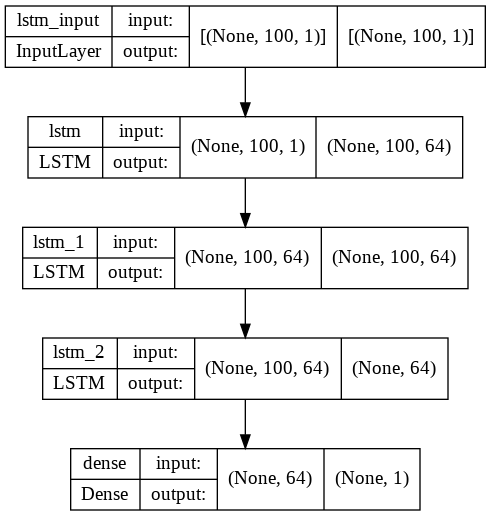

In [32]:
plot_model(model, show_shapes=True, show_layer_names=True)